## LHIPA calculation with blinks, no stitch for multiple visit in same stimuli
### input file
* gs_data_ET_gaze_valid.csv (valid gaze data with blink data)

### output file

In [2]:
import pandas as pd
import numpy as np
import math, pywt
import matplotlib.pyplot as plt

In [3]:
def modmax(d): 
    # compute signal modulus 
    m = [0.0]*len(d) 
    for i in range(len(d)): 
        m[i] = math.fabs(d[i]) 
        
    # if value is larger than both neighbours , and strictly 
    # larger than either, then it is a local maximum 
    t = [0.0]*len(d) 
    for i in range(len(d)): 
        ll = m[i-1] if i >= 1 else m[i] 
        oo = m[i] 
        rr = m[i+1] if i < len(d)-2 else m[i] 
        if (ll <= oo and oo >= rr) and (ll < oo or oo > rr): 
            # compute magnitude 
            t[i] = math.sqrt(d[i]**2) 
        else: 
            t[i] = 0.0 
            
    return t

In [4]:
def lhipa_new(d):
    # find max decomposition level
    w = pywt.Wavelet('sym16')
    maxlevel = pywt.dwt_max_level(len(d[0]),filter_len=w.dec_len)
    # print(maxlevel)
    
    # set high and low frequency band indeces
    hif, lof = 1, int(maxlevel/2)
    
    # get detail coefficients of pupil diameter signal d
    cD_H = pywt.downcoef('d', d[0], 'sym16', 'per', level = hif)
    cD_L = pywt.downcoef('d', d[0], 'sym16', 'per', level = lof)
    
    # normalize by 1/root(2^(j))
    cD_H[:] = [x / math.sqrt(2**hif) for x in cD_H]
    cD_L[:] = [x / math.sqrt(2**lof) for x in cD_L]
    
    # obtain the LH:HF ratio
    cD_LH = cD_L
    for i in range(len(cD_L)):
        cD_LH[i] = cD_L[i] / cD_H[((2**lof)//(2**hif))*i]
        
    # detect modulus maxima, see Duchowski et al.
    cD_LHm = modmax(cD_LH)
    
    # threshold using universal threshold λuniv = σˆ (2 log n)
    # where σˆ is the standard deviation of the noise
    λuniv = np.std(cD_LHm) * math.sqrt(2.0*np.log2(len(cD_LHm))) 
    cD_LHt = pywt.threshold(cD_LHm, λuniv, mode ="less")
    
    # get signal duration (in seconds)
    tt = (d[1][-1] - d[1][0]) / 1000
    
    # compute LHIPA
    ctr = 0
    for i in range(len(cD_LHt)):
        if math.fabs(cD_LHt[i]) > 0: ctr += 1
    LHIPA = float(ctr)/tt
    
    return LHIPA

### lhipa for each aoi

In [5]:
gaze_df = pd.read_csv('/Volumes/Extreme SSD/research data/good system/database tables/gs_local_gazeWithBlink_pupil_aoi.csv')
gaze_df.head()

,imotion_unix_timestamp,user_id,SourceStimuliName,gaze_AOI,Blink_detected,ET_PupilLeft,ET_PupilRight,ET_ValidityLeft,ET_ValidityRight,Fixation Index
0,1628616621280,P001,A2002,fc_row_5_src_rep,NaN,3.515396,3.655457,0,0,2858.0
1,1628616621284,P001,A2002,fc_row_5_src_rep,0.0,3.511688,3.648514,0,0,2858.0
2,1628616621287,P001,A2002,fc_row_5_src_rep,0.0,3.507050,3.617889,0,0,2858.0
3,1628616621290,P001,A2002,fc_row_5_src_rep,NaN,3.514343,3.643295,0,0,2858.0
4,1628616621294,P001,A2002,fc_row_5_src_rep,0.0,3.525589,3.646912,0,0,2858.0


In [6]:
gaze_df['ET_pupilAvg']=0
gaze_df.loc[(gaze_df['ET_ValidityLeft']==0) & (gaze_df['ET_ValidityRight']==0),['ET_pupilAvg']] = \
(gaze_df[(gaze_df['ET_ValidityLeft']==0) & (gaze_df['ET_ValidityRight']==0)]['ET_PupilLeft']+gaze_df[(gaze_df['ET_ValidityLeft']==0) & (gaze_df['ET_ValidityRight']==0)]['ET_PupilRight'])/2
gaze_df.loc[(gaze_df['ET_ValidityLeft']==0) & (gaze_df['ET_ValidityRight']==4),['ET_pupilAvg']] = \
gaze_df[(gaze_df['ET_ValidityLeft']==0) & (gaze_df['ET_ValidityRight']==4)]['ET_PupilLeft']
gaze_df.loc[(gaze_df['ET_ValidityLeft']==4) & (gaze_df['ET_ValidityRight']==0),['ET_pupilAvg']] = \
gaze_df[(gaze_df['ET_ValidityLeft']==4) & (gaze_df['ET_ValidityRight']==0)]['ET_PupilRight']

In [7]:
gaze_df.head()

,imotion_unix_timestamp,user_id,SourceStimuliName,gaze_AOI,Blink_detected,ET_PupilLeft,ET_PupilRight,ET_ValidityLeft,ET_ValidityRight,Fixation Index,ET_pupilAvg
0,1628616621280,P001,A2002,fc_row_5_src_rep,NaN,3.515396,3.655457,0,0,2858.0,3.585426
1,1628616621284,P001,A2002,fc_row_5_src_rep,0.0,3.511688,3.648514,0,0,2858.0,3.580101
2,1628616621287,P001,A2002,fc_row_5_src_rep,0.0,3.507050,3.617889,0,0,2858.0,3.562469
3,1628616621290,P001,A2002,fc_row_5_src_rep,NaN,3.514343,3.643295,0,0,2858.0,3.578819
4,1628616621294,P001,A2002,fc_row_5_src_rep,0.0,3.525589,3.646912,0,0,2858.0,3.586250


In [8]:
df_fix = pd.read_csv('/Volumes/Extreme SSD/research data/good system/database tables/gs_data_ET_fixation_label.csv')
df_fix.head()

,userid,claim_id,ui,imotion_unix_timestamp,fixation_index,fixation_x,fixation_y,fixation_duration,AOI
0,P001,2002,A,1628616621280,2858,508.008642,650.866667,1349.81770,fc_row_5_src_rep
1,P001,2002,A,1628616621674,2859,215.234694,201.908163,163.35375,fc_heading_src_name
2,P001,2002,A,1628616621890,2860,187.616426,144.592558,203.31450,header_txt
3,P001,2002,A,1628616622147,2861,350.763158,250.618421,126.65200,fc_row_1_src_rep
4,P001,2002,A,1628616622307,2862,476.639299,240.383130,309.95885,fc_row_1_src_rep


In [9]:
gaze_aoi_selected = gaze_df.loc[:,['imotion_unix_timestamp','user_id','SourceStimuliName','gaze_AOI','Fixation Index','ET_pupilAvg']]
gaze_aoi_selected.head()

,imotion_unix_timestamp,user_id,SourceStimuliName,gaze_AOI,Fixation Index,ET_pupilAvg
0,1628616621280,P001,A2002,fc_row_5_src_rep,2858.0,3.585426
1,1628616621284,P001,A2002,fc_row_5_src_rep,2858.0,3.580101
2,1628616621287,P001,A2002,fc_row_5_src_rep,2858.0,3.562469
3,1628616621290,P001,A2002,fc_row_5_src_rep,2858.0,3.578819
4,1628616621294,P001,A2002,fc_row_5_src_rep,2858.0,3.586250


In [9]:
temp = df_fix.loc[:,['userid','claim_id','ui','fixation_index','AOI']]
temp['stimuliName'] = temp['ui']+ temp['claim_id'].astype(str)
temp.head()

,userid,claim_id,ui,fixation_index,AOI,stimuliName
0,P001,2002,A,2858,fc_row_5_src_rep,A2002
1,P001,2002,A,2859,fc_heading_src_name,A2002
2,P001,2002,A,2860,header_txt,A2002
3,P001,2002,A,2861,fc_row_1_src_rep,A2002
4,P001,2002,A,2862,fc_row_1_src_rep,A2002


In [10]:
temp = temp.loc[:,['userid','stimuliName','fixation_index','AOI']]
gaze_aoi_new = gaze_aoi_selected.merge(temp, left_on=['user_id','SourceStimuliName','Fixation Index'], right_on=['userid','stimuliName','fixation_index'], how='left')
gaze_aoi_new.head()

,imotion_unix_timestamp,user_id,SourceStimuliName,gaze_AOI,Fixation Index,ET_pupilAvg,userid,stimuliName,fixation_index,AOI
0,1628616621280,P001,A2002,fc_row_5_src_rep,2858.0,3.585426,P001,A2002,2858.0,fc_row_5_src_rep
1,1628616621284,P001,A2002,fc_row_5_src_rep,2858.0,3.580101,P001,A2002,2858.0,fc_row_5_src_rep
2,1628616621287,P001,A2002,fc_row_5_src_rep,2858.0,3.562469,P001,A2002,2858.0,fc_row_5_src_rep
3,1628616621290,P001,A2002,fc_row_5_src_rep,2858.0,3.578819,P001,A2002,2858.0,fc_row_5_src_rep
4,1628616621294,P001,A2002,fc_row_5_src_rep,2858.0,3.586250,P001,A2002,2858.0,fc_row_5_src_rep


In [11]:
pd.options.display.max_columns = None

In [12]:
gaze_aoi_new.rename(columns = {'AOI':'fix_AOI'}, inplace = True)
gaze_aoi_new.head()

,imotion_unix_timestamp,user_id,SourceStimuliName,gaze_AOI,Fixation Index,ET_pupilAvg,userid,stimuliName,fixation_index,fix_AOI
0,1628616621280,P001,A2002,fc_row_5_src_rep,2858.0,3.585426,P001,A2002,2858.0,fc_row_5_src_rep
1,1628616621284,P001,A2002,fc_row_5_src_rep,2858.0,3.580101,P001,A2002,2858.0,fc_row_5_src_rep
2,1628616621287,P001,A2002,fc_row_5_src_rep,2858.0,3.562469,P001,A2002,2858.0,fc_row_5_src_rep
3,1628616621290,P001,A2002,fc_row_5_src_rep,2858.0,3.578819,P001,A2002,2858.0,fc_row_5_src_rep
4,1628616621294,P001,A2002,fc_row_5_src_rep,2858.0,3.586250,P001,A2002,2858.0,fc_row_5_src_rep


In [13]:
# 按照ts排序
# 找到连续的在同一 AOI超过两个的fixation
# 用fixation ID, userid, claim id 找到对应的gaze的起始和结束点

In [55]:
gaze_aoi_selected = gaze_aoi_selected.sort_values(by=['imotion_unix_timestamp'])
gaze_aoi_selected.head()

,imotion_unix_timestamp,user_id,SourceStimuliName,gaze_AOI,Fixation Index,ET_pupilAvg
0,1628616621280,P001,A2002,fc_row_5_src_rep,2858.0,3.585426
1,1628616621284,P001,A2002,fc_row_5_src_rep,2858.0,3.580101
2,1628616621287,P001,A2002,fc_row_5_src_rep,2858.0,3.562469
3,1628616621290,P001,A2002,fc_row_5_src_rep,2858.0,3.578819
4,1628616621294,P001,A2002,fc_row_5_src_rep,2858.0,3.586250


In [14]:
temp = df_fix.loc[:,['userid','claim_id','ui','fixation_index','AOI', 'imotion_unix_timestamp']]
temp['stimuliName'] = temp['ui']+ temp['claim_id'].astype(str)
temp = temp.loc[:,['userid','stimuliName','fixation_index','AOI', 'imotion_unix_timestamp']]
temp.head()

,userid,stimuliName,fixation_index,AOI,imotion_unix_timestamp
0,P001,A2002,2858,fc_row_5_src_rep,1628616621280
1,P001,A2002,2859,fc_heading_src_name,1628616621674
2,P001,A2002,2860,header_txt,1628616621890
3,P001,A2002,2861,fc_row_1_src_rep,1628616622147
4,P001,A2002,2862,fc_row_1_src_rep,1628616622307


In [15]:
fix_df= temp.sort_values(by=['imotion_unix_timestamp'])
fix_df.head()

,userid,stimuliName,fixation_index,AOI,imotion_unix_timestamp
0,P001,A2002,2858,fc_row_5_src_rep,1628616621280
1,P001,A2002,2859,fc_heading_src_name,1628616621674
2,P001,A2002,2860,header_txt,1628616621890
3,P001,A2002,2861,fc_row_1_src_rep,1628616622147
4,P001,A2002,2862,fc_row_1_src_rep,1628616622307


In [56]:
fix_series = pd.DataFrame(columns=['userid','claim_id','aoi','start_index','end_index'])
cur_aoi = 'fc_row_5_src_rep'
start_id, end_id = 0,0
cur_user = 'P001'
cur_claim = 'A2002'
pre_id = 0

for index, row in fix_df.iterrows():
    # print(f"current AOI: {cur_aoi}, current user: {cur_user}, current claim: {cur_claim}, start_id: {start_id}, end_id:{end_id}, pre_id:{pre_id}")
    if row['AOI']==cur_aoi and row['userid']==cur_user and row['stimuliName']==cur_claim:
        if start_id == 0: 
            start_id = row['fixation_index']
            
        elif row['fixation_index']==pre_id+1:
            end_id = row['fixation_index']
            
    else:
        # print ("judge append")
        if start_id!= 0 and end_id != 0:
            # print("append")
            new_row = {'userid': cur_user, 'claim_id': cur_claim, 'aoi': cur_aoi, 'start_index': start_id, 'end_index': end_id}
            fix_series = fix_series.append(new_row, ignore_index=True)
        
        cur_aoi = row['AOI']
        start_id, end_id = row['fixation_index'],0
        cur_user = row['userid']
        cur_claim = row['stimuliName']
        
    pre_id = row['fixation_index']
    # if index == 100: break

In [57]:
fix_series.head()

,userid,claim_id,aoi,start_index,end_index
0,P001,A2002,fc_row_1_src_rep,2861,2864
1,P001,A2002,fc_row_1_news_headline,2865,2871
2,P001,A2002,fc_row_2_src_rep,2873,2874
3,P001,A2002,fc_row_3_src_rep,2875,2876
4,P001,A2002,fc_row_2_src_rep,2877,2883


In [58]:
fix_series.shape

(15578, 5)

In [59]:
ipa_df2 = pd.DataFrame(columns=['userid','claim_id','start_ts','end_ts','aoi','LHIPA','gaze_cnt'])

for index,row in fix_series.iterrows():
    start_ts = gaze_aoi_selected[(gaze_aoi_selected['Fixation Index']==row['start_index']) & \
                      (gaze_aoi_selected['user_id']==row['userid']) & 
                      (gaze_aoi_selected['SourceStimuliName']==row['claim_id'])]['imotion_unix_timestamp'].min()
    end_ts = gaze_aoi_selected[(gaze_aoi_selected['Fixation Index']==row['end_index']) & \
                      (gaze_aoi_selected['user_id']==row['userid']) & 
                      (gaze_aoi_selected['SourceStimuliName']==row['claim_id'])]['imotion_unix_timestamp'].max()
    
    gaze_tocal = gaze_aoi_selected[(gaze_aoi_selected['imotion_unix_timestamp']>= start_ts) & (gaze_aoi_selected['imotion_unix_timestamp']<= end_ts)]
    gaze_tocal = gaze_tocal.sort_values(by=['imotion_unix_timestamp'])
    pupil_list = []
    ts_list = []
    for index1, row1 in gaze_tocal.iterrows():
        pupil_list.append(row1['ET_pupilAvg'])
        ts_list.append(row1['imotion_unix_timestamp'])

    ipa_list = [pupil_list, ts_list]
    
    if len(pupil_list)>125:
        lhipa = lhipa_new(ipa_list)
        if index%50==0: print(f"this is row {index}, IPA: {lhipa}")        
        new_row = {'userid': row['userid'], 'claim_id': row['claim_id'], 'start_ts': start_ts, 
                   'end_ts': end_ts, 'aoi': row['aoi'], 'LHIPA': lhipa, 'gaze_cnt': len(pupil_list)}
        ipa_df2 = ipa_df2.append(new_row, ignore_index=True)

this is row 0, IPA: 0.0
this is row 50, IPA: 0.0
this is row 200, IPA: 0.0
this is row 250, IPA: 0.0
this is row 300, IPA: 24.48163877092181
this is row 400, IPA: 23.604176123468
this is row 450, IPA: 21.101992966002346
this is row 550, IPA: 0.0
this is row 600, IPA: 0.0
this is row 700, IPA: 0.0
this is row 750, IPA: 0.0
this is row 800, IPA: 0.0
this is row 900, IPA: 0.0
this is row 950, IPA: 0.0
this is row 1050, IPA: 0.0
this is row 1100, IPA: 0.0
this is row 1150, IPA: 0.0
this is row 1200, IPA: 0.0
this is row 1450, IPA: 0.0
this is row 1600, IPA: 0.0
this is row 1650, IPA: 0.0
this is row 1750, IPA: 0.0
this is row 1800, IPA: 0.0
this is row 1900, IPA: 23.255813953488374
this is row 2000, IPA: 0.0
this is row 2050, IPA: 24.83974358974359
this is row 2100, IPA: 0.0
this is row 2150, IPA: 0.0
this is row 2200, IPA: 0.0
this is row 2300, IPA: 0.0
this is row 2350, IPA: 0.0
this is row 2400, IPA: 0.0
this is row 2450, IPA: 0.0
this is row 2500, IPA: 24.398451960289417
this is row 25

### lhipa for each stimuli (avg for all visits)

In [10]:
visit_ts = pd.read_csv('/Volumes/Extreme SSD/research data/good system/database tables/news_visited_ts.csv')
visit_ts.head()

,userid,claim_id,ui,news_visits_startts,news_visits_endts
0,P001,2002,A,1628616651702,1628616686647
1,P001,2002,A,1628616688343,1628616749773
2,P001,2002,A,1628616752423,1628616801523
3,P001,2011,A,1628616896935,1628616958264
4,P001,2006,A,1628617114904,1628617133233


In [11]:
gaze_aoi_selected.head()

,imotion_unix_timestamp,user_id,SourceStimuliName,gaze_AOI,Fixation Index,ET_pupilAvg
0,1628616621280,P001,A2002,fc_row_5_src_rep,2858.0,3.585426
1,1628616621284,P001,A2002,fc_row_5_src_rep,2858.0,3.580101
2,1628616621287,P001,A2002,fc_row_5_src_rep,2858.0,3.562469
3,1628616621290,P001,A2002,fc_row_5_src_rep,2858.0,3.578819
4,1628616621294,P001,A2002,fc_row_5_src_rep,2858.0,3.586250


In [12]:
gaze_aoi_selected = gaze_aoi_selected.sort_values('imotion_unix_timestamp')
gaze_aoi_selected.head()

,imotion_unix_timestamp,user_id,SourceStimuliName,gaze_AOI,Fixation Index,ET_pupilAvg
0,1628616621280,P001,A2002,fc_row_5_src_rep,2858.0,3.585426
1,1628616621284,P001,A2002,fc_row_5_src_rep,2858.0,3.580101
2,1628616621287,P001,A2002,fc_row_5_src_rep,2858.0,3.562469
3,1628616621290,P001,A2002,fc_row_5_src_rep,2858.0,3.578819
4,1628616621294,P001,A2002,fc_row_5_src_rep,2858.0,3.586250


In [27]:
# calculate LHIPA per claim per user
userid = gaze_aoi_selected.iloc[0,1]
claimid = gaze_aoi_selected.iloc[0,2]
pupil_list = []
ts_list = []
pivot="in"

ipa_df_cl = pd.DataFrame(columns=['userid','claim_id','start_ts','end_ts','LHIPA','gaze_cnt_total','visit_cnt'])

for index,row in gaze_aoi_selected.iterrows():
    # print(row)
    if index%5000==0:
        print(f"processing row {index}...")
    if row['user_id']==userid and row['SourceStimuliName']==claimid:
        pupil_list.append(row['ET_pupilAvg'])
        ts_list.append(row['imotion_unix_timestamp'])
        
    else:
        gc = 0
        vc = 0
        # print(row)
        # judge if need to calculate LHIPA (count>125)
        if len(pupil_list)>125:
            visit_split = visit_ts[(visit_ts['claim_id']==int(claimid[1:]))&\
                                   (visit_ts['ui']==claimid[0])&\
                                   (visit_ts['userid']==userid)]
            
            # if there is news reading
            if visit_split.shape[0]!=0:
                ipa_list = []
                split_index = []
                for index1,row1 in visit_split.iterrows(): 
                    if index1 == 0:
                        split_index.append([i for i in range(len(ts_list)) if (ts_list[i]<row1['news_visits_startts'])])
                    else:
                        split_index.append([i for i in range(len(ts_list)) if (ts_list[i]>next_lw and ts_list[i]<row1['news_visits_startts'])])
                        if index1 == visit_split.shape[0]:
                            split_index.append([i for i in range(len(ts_list)) if (ts_list[i]>row1['news_visits_endts'])])
                    next_lw = row1['news_visits_endts']
                
                for j in range(len(split_index)):
                    pupil_list1 = []
                    ts_list1 = []
                    if len(split_index[j])>125:
                        for m in split_index[j]:
                            pupil_list1.append(pupil_list[m])
                            ts_list1.append(ts_list[m])
                        ipa_list.append([pupil_list1, ts_list1])
                        gc = gc + len(pupil_list1)
                    
                lhipa_list = []
                for k in range(len(ipa_list)):
                    lhipa_list.append(lhipa_new(ipa_list[k]))
                
                if len(lhipa_list)==0:
                    pivot="out"
                else:
                    lhipa = sum(lhipa_list) / len(lhipa_list)
                    vc = len(lhipa_list)
            
            # if no news reading
            else:
                ipa_list = [pupil_list, ts_list]
                lhipa = lhipa_new(ipa_list)
                gc = len(pupil_list)
                vc = 1
            
            # all the list to calculate ipa should larger than 125
            if pivot != "out":
                print(f"userid: {userid}, claim_id: {claimid}, lhipa:{lhipa}")
                new_row = {'userid': userid, 'claim_id': claimid, 'start_ts': ts_list[0], 
                           'end_ts': ts_list[-1], 'LHIPA': lhipa, 'gaze_cnt': gc, 'visit_cnt':vc}
                ipa_df_cl = ipa_df_cl.append(new_row, ignore_index=True)
            
        # print(f"this is error: {row}...error")
        userid = row['user_id']
        claimid = row['SourceStimuliName']
        pupil_list = [row['ET_pupilAvg']]
        ts_list = [row['imotion_unix_timestamp']]
        pivot="in"

processing row 0...
userid: P001, claim_id: A2002, lhipa:18.138953919453684
userid: P001, claim_id: A2011, lhipa:12.50142061597909
processing row 2785000...
processing row 2980000...
userid: P001, claim_id: A2006, lhipa:18.345049575261488
processing row 2345000...
userid: P001, claim_id: A2012, lhipa:11.793493824072398
userid: P001, claim_id: A1009, lhipa:12.281835811247575
processing row 1760000...
userid: P001, claim_id: A1005, lhipa:11.65759156078727
processing row 1955000...
processing row 4885000...
processing row 5520000...
processing row 1175000...
processing row 3860000...
userid: P001, claim_id: A1007, lhipa:6.43121364215438
processing row 1370000...
processing row 5960000...
processing row 5765000...
userid: P001, claim_id: A1001, lhipa:20.161762038918425
processing row 4300000...
userid: P001, claim_id: A2001, lhipa:18.643761292416908
processing row 3420000...
processing row 590000...
processing row 200000...
processing row 4105000...
userid: P001, claim_id: A1006, lhipa:6.0

In [28]:
ipa_df_cl.head()

,userid,claim_id,start_ts,end_ts,LHIPA,gaze_cnt_total,visit_cnt,gaze_cnt
0,P001,A2002,1628616621280,1628616803216,18.138954,NaN,3,10282.0
1,P001,A2011,1628616888135,1628616960309,12.501421,NaN,1,2610.0
2,P001,A2006,1628617082280,1628617285176,18.345050,NaN,3,12035.0
3,P001,A2012,1628617464469,1628617524278,11.793494,NaN,2,7503.0
4,P001,A1009,1628617588426,1628617636953,12.281836,NaN,1,3164.0


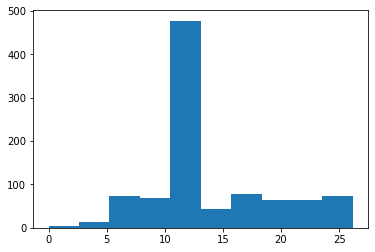

In [29]:
# plt.hist(ipa_df[ipa_df['LHIPA']>15]['gaze_cnt'])
plt.hist(ipa_df_cl['LHIPA'])
plt.show()

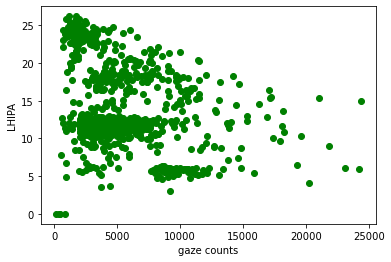

In [30]:
plt.scatter(ipa_df_cl['gaze_cnt'], ipa_df_cl['LHIPA'], c ="green")
plt.xlabel("gaze counts") #x label
plt.ylabel("LHIPA") #y label
plt.show()

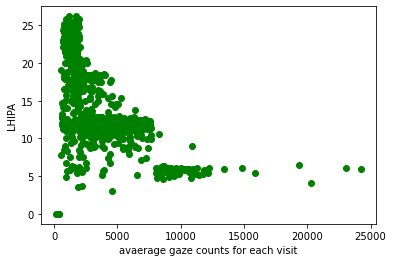

In [31]:
plt.scatter(ipa_df_cl['gaze_cnt']/ipa_df_cl['visit_cnt'], ipa_df_cl['LHIPA'], c ="green")
plt.xlabel("avaerage gaze counts for each visit") #x label
plt.ylabel("LHIPA") #y label
plt.show()

In [16]:
plt.scatter(ipa_df2['gaze_cnt'], ipa_df2['LHIPA'], c ="green")
plt.xlabel("gaze counts") #x label
plt.ylabel("LHIPA") #y label
plt.show()

NameError: name 'ipa_df2' is not defined

In [17]:
ipa_df_cl.head()

,userid,claim_id,start_ts,end_ts,LHIPA,gaze_cnt
0,P001,A2002,1628616621280,1628616803216,18.138954,10790
1,P001,A2011,1628616888138,1628616960309,12.619372,3223
2,P001,A2006,1628617082283,1628617285176,18.406539,12847
3,P001,A2012,1628617464473,1628617524278,11.987305,8313
4,P001,A1009,1628617588430,1628617636953,11.270208,4116


In [18]:
ipa_df_cl['ui'] = ''
for index, row in ipa_df_cl.iterrows():
    # print(index)
    ipa_df_cl.iloc[index, 6] = row['claim_id'][0]
ipa_df_cl.head(5)

,userid,claim_id,start_ts,end_ts,LHIPA,gaze_cnt,ui
0,P001,A2002,1628616621280,1628616803216,18.138954,10790,A
1,P001,A2011,1628616888138,1628616960309,12.619372,3223,A
2,P001,A2006,1628617082283,1628617285176,18.406539,12847,A
3,P001,A2012,1628617464473,1628617524278,11.987305,8313,A
4,P001,A1009,1628617588430,1628617636953,11.270208,4116,A


In [32]:
plt.boxplot([ipa_df_cl[ipa_df_cl['ui']=='A']['LHIPA'], ipa_df_cl[ipa_df_cl['ui']=='B']['LHIPA']])
plt.xlabel("UI") #x label
plt.ylabel("LHIPA") #y label
plt.show()

KeyError: 'ui'

In [20]:
ipa_df_cl.shape

(959, 7)

In [21]:
claim_info = pd.read_csv('/Users/lishi/Documents/research/Good System/data/claim.csv')
claim_info.head()

,userid,claim_id,AOI_string,valid_AOI_string,ui,st_time,end_time,fixation_duration_mean,fixation_duration_std,total_dwell_time,interface_use_time,news_reading_time,MWlevel,correctness
0,P001,2002,REXRHRHAEARHARSRSRSRCRSRSRSRHRHAHRHRCHRHCBCBR,RHRHARHARSRSRSRCRSRSRSRHRHAHRHRCHRHCR,A,1628616621315,1628616803087,248.892463,156.389441,181772,36297,145475,high,mix
1,P001,2011,XRCRHRHAHRHBCR,CRHRHAHRHCR,A,1628616888166,1628616960242,222.369650,95.347616,72076,10747,61329,high,false
2,P001,2006,XRHRHARSRHAHRHARHRHRHBCRSRSRHRHARHRHARCBCB,HRHARSRHAHRHARHRHRHCRSRSRHRHARHRHARC,A,1628617082318,1628617285093,223.236489,92.632922,202775,43600,159175,high,false
3,P001,2012,CXERHRAEARSRHRCRHRHACBHRHRHRHRSCBCBCR,CRHRARSRHRCRHRHACHRHRHRHRSCR,A,1628617464518,1628617524191,238.026256,117.681359,59673,28356,31317,high,false
4,P001,1009,RERHACRHRHRHSRHBR,RHACRHRHRHSRHR,A,1628617588465,1628617636889,226.276773,96.029932,48424,14007,34417,high,true


In [22]:
claim_MW = claim_info[['userid','claim_id','MWlevel']].copy()
claim_MW.head()

,userid,claim_id,MWlevel
0,P001,2002,high
1,P001,2011,high
2,P001,2006,high
3,P001,2012,high
4,P001,1009,high


In [23]:
ipa_df_cl['claim_num'] = ''
for index, row in ipa_df_cl.iterrows():
    ipa_df_cl.iloc[index, -1] = row['claim_id'][1:]
ipa_df_cl.head(5)

,userid,claim_id,start_ts,end_ts,LHIPA,gaze_cnt,ui,claim_num
0,P001,A2002,1628616621280,1628616803216,18.138954,10790,A,2002
1,P001,A2011,1628616888138,1628616960309,12.619372,3223,A,2011
2,P001,A2006,1628617082283,1628617285176,18.406539,12847,A,2006
3,P001,A2012,1628617464473,1628617524278,11.987305,8313,A,2012
4,P001,A1009,1628617588430,1628617636953,11.270208,4116,A,1009


In [24]:
ipa_df_cl['claim_num'] = pd.to_numeric(ipa_df_cl['claim_num'])
ipa_df_cl.head()

,userid,claim_id,start_ts,end_ts,LHIPA,gaze_cnt,ui,claim_num
0,P001,A2002,1628616621280,1628616803216,18.138954,10790,A,2002
1,P001,A2011,1628616888138,1628616960309,12.619372,3223,A,2011
2,P001,A2006,1628617082283,1628617285176,18.406539,12847,A,2006
3,P001,A2012,1628617464473,1628617524278,11.987305,8313,A,2012
4,P001,A1009,1628617588430,1628617636953,11.270208,4116,A,1009


In [25]:
ipa_df_cl2 = ipa_df_cl.merge(claim_MW, left_on=['userid','claim_num'], right_on=['userid','claim_id'], how='left')
ipa_df_cl2.head()

,userid,claim_id_x,start_ts,end_ts,LHIPA,gaze_cnt,ui,claim_num,claim_id_y,MWlevel
0,P001,A2002,1628616621280,1628616803216,18.138954,10790,A,2002,2002.0,high
1,P001,A2011,1628616888138,1628616960309,12.619372,3223,A,2011,2011.0,high
2,P001,A2006,1628617082283,1628617285176,18.406539,12847,A,2006,2006.0,high
3,P001,A2012,1628617464473,1628617524278,11.987305,8313,A,2012,2012.0,high
4,P001,A1009,1628617588430,1628617636953,11.270208,4116,A,1009,1009.0,high


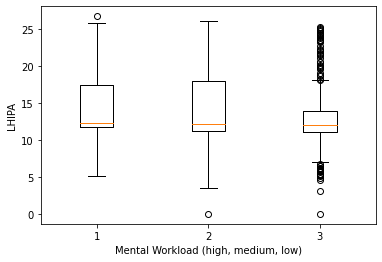

In [26]:
plt.boxplot([ipa_df_cl2[ipa_df_cl2['MWlevel']=='high']['LHIPA'],ipa_df_cl2[ipa_df_cl2['MWlevel']=='medium']['LHIPA'],\
             ipa_df_cl2[ipa_df_cl2['MWlevel']=='low']['LHIPA']])
plt.ylabel("LHIPA") #y label
plt.xlabel("Mental Workload (high, medium, low)")
plt.show()

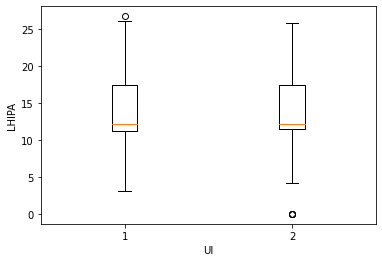

In [33]:
plt.boxplot([ipa_df_cl2[ipa_df_cl2['ui']=='A']['LHIPA'], ipa_df_cl2[ipa_df_cl2['ui']=='B']['LHIPA']])
plt.xlabel("UI") #x label
plt.ylabel("LHIPA") #y label
plt.show()

In [61]:
ipa_df2.to_csv('/Volumes/Extreme SSD/research data/good system/database tables/lhipa_perAOI_fixfilter_withblink.csv', index=False)

In [62]:
ipa_df_cl2.to_csv('/Volumes/Extreme SSD/research data/good system/database tables/lhipa_perclaim_withblink.csv', index=False)